# BetaVAE on CARS196 dataset

The <a href="https://www.tensorflow.org/datasets/catalog/cars196">cars196</a> dataset contains 16,185 images of 196 different types of cars, which
can be used to train a supervised learning system to determine the make and model of a vehicle in a photograph.

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import model
from model import *

In [20]:
height, width, depth = 128, 192, 1
batch_size = 32
pad = 10 # padding for cropping
filters = [64,32,16]
latent_dim = 10
image_size = (height, width, depth)
last_convdims = (int(height/(2**(len(filters)))),
                 int(width/(2**(len(filters)))))

Let's get the data. Working on your machine, change `download` to `True` and change `DATA_DIR` to the name of the local directory you want to download the data to.

In [21]:
DATA_DIR = './cars196'

[train_ds, test_ds], ds_info = tfds.load(
    "cars196",
    # Reserve 10% for validation and 50% for test
    split=["train", "test"],
    as_supervised=True,  # Include labels
    with_info=True,
    download=True,
    data_dir=DATA_DIR,
)

Now, let's use the built-in visualization function to show some example images:

In [22]:
#tfds.visualization.show_examples(train_ds, ds_info)

## Resize images

In [23]:
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (height, width))))
#validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, (height, width))))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, (height, width))))
train_ds

<MapDataset shapes: (128, 192, 3), types: tf.float32>

## RGB to BW

In [24]:
train_ds = train_ds.map(lambda x: (tf.image.rgb_to_grayscale(x)))
#validation_ds = validation_ds.map(lambda x: (tf.image.rgb_to_grayscale(x)))
test_ds = test_ds.map(lambda x: (tf.image.rgb_to_grayscale(x)))
train_ds

<MapDataset shapes: (128, 192, 1), types: tf.float32>

## Random data augmentation

Let's the data and use caching and prefetching to optimize load speed:

In [25]:
def augment_func(image):
    image = tf.image.resize_with_crop_or_pad(image,height+pad,width+pad)
    #image = tf.clip_by_value(image,0,255) #make sure you have no color value higher than 225 or lower than 0.
    image = tf.image.random_crop(image,size=[height,width,depth])
    image = tf.image.random_flip_left_right(image) #different aspect of vehicles
    #image = tf.image.random_hue(image,0.2) #random color, change a red cat into a blue car
    #image = tf.image.random_contrast(image,0.5,2)# random contrast
    #image = tf.image.random_saturation(image,0,2)# random sturations
    return image

# cache makes the images ready before running
train_ds = train_ds.cache().map(augment_func).shuffle(100).batch(batch_size).prefetch(buffer_size=10) 
test_ds = test_ds.cache().map(augment_func).batch(batch_size).prefetch(buffer_size=10)

## Normalize images
Pixel values from range (0,255) to range (0,1)

In [26]:
train_ds = train_ds.map(lambda x: x / 255.)
#validation_ds = validation_ds.map(lambda x: x / 255.)
test_ds = test_ds.map(lambda x: x / 255.)
train_ds

<MapDataset shapes: (None, 128, 192, 1), types: tf.float32>

Let's visualize what the first 18 images of the first batch looks like after various random transformations.

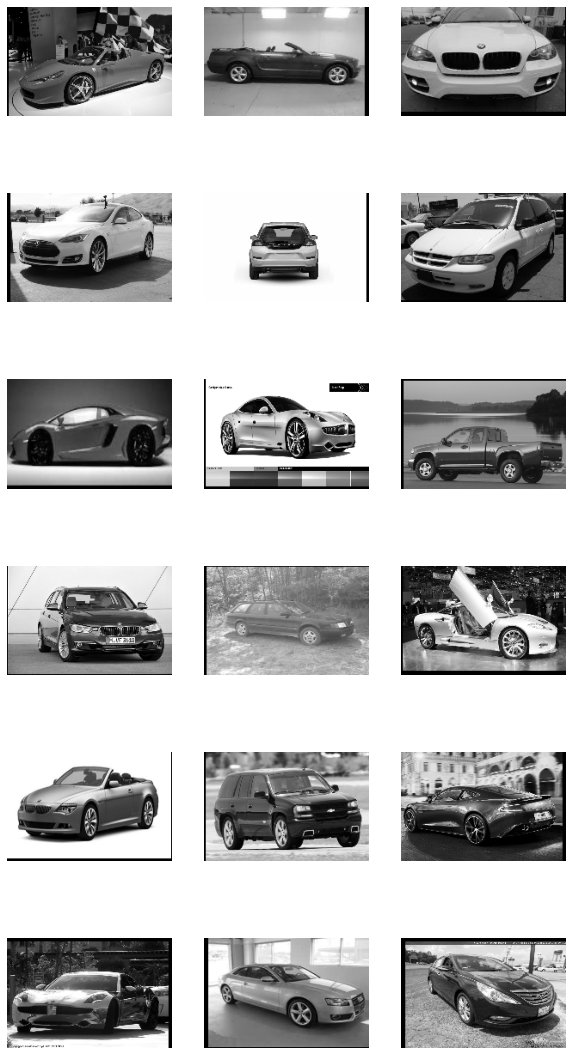

In [48]:
plt.figure(figsize=(10, 20))
for i, image_batch in enumerate(train_ds.take(18)): # we did batch(batch_size) before, if we didn't, "take" will take individual image.
        ax = plt.subplot(6, 3, i + 1)
        plt.imshow(image_batch[3,:,:,:].numpy(),cmap='binary_r')
        plt.axis("off")


## Build a model

In [28]:
encoder10 = Encoder(filters=filters,latent_dim=latent_dim,image_shape=image_size)
encoder10.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 192, 1) 0                                            
__________________________________________________________________________________________________
conv_layer_1 (Conv2D)           (None, 64, 96, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
conv_norm_1 (BatchNormalization (None, 64, 96, 64)   256         conv_layer_1[0][0]               
__________________________________________________________________________________________________
conv_relu_1 (ReLU)              (None, 64, 96, 64)   0           conv_norm_1[0][0]                
____________________________________________________________________________________________

In [29]:
decoder10 = Decoder(latent_dim=latent_dim,filters=filters,last_convdims=last_convdims, img_depth=depth)
decoder10.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_input (InputLayer)    [(None, 10)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 6144)              67584     
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 24, 16)        0         
_________________________________________________________________
deconv2d_1 (Conv2DTranspose) (None, 32, 48, 16)        2320      
_________________________________________________________________
deconv_norm_1 (BatchNormaliz (None, 32, 48, 16)        64        
_________________________________________________________________
deconv_relu_1 (ReLU)         (None, 32, 48, 16)        0         
_________________________________________________________________
deconv2d_2 (Conv2DTranspose) (None, 64, 96, 32)        4640

In [30]:
vae10 = VAE(encoder10,decoder10,beta=2.)
vae10.compile(optimizer=keras.optimizers.Adam())
vae10.fit(train_ds, epochs=5, batch_size=batch_size)

Epoch 1/5
255/255 [==============================] - 590s 2s/step - Total_loss: 16481.2754 - Reconstruction_loss: 16462.5039 - KL_loss: 9.3854
Epoch 2/5
255/255 [==============================] - 706s 3s/step - Total_loss: 16147.8252 - Reconstruction_loss: 16126.4004 - KL_loss: 10.7139
Epoch 3/5
255/255 [==============================] - 621s 2s/step - Total_loss: 15986.2510 - Reconstruction_loss: 15960.6406 - KL_loss: 12.8048
Epoch 4/5
255/255 [==============================] - 748s 3s/step - Total_loss: 15773.4346 - Reconstruction_loss: 15737.2041 - KL_loss: 18.1188
Epoch 5/5
255/255 [==============================] - 605s 2s/step - Total_loss: 15731.2432 - Reconstruction_loss: 15696.7588 - KL_loss: 17.2428


In [31]:
for image_batch in train_ds.take(1):
    images = image_batch.numpy()

i = 5
image = images[i,:,:,:]
img = np.expand_dims(image, 0)
vae_model = vae10

In [46]:
def show_reconstr_hor(image,vae_model):
    img = np.expand_dims(image, 0)
    z_mean,_,_ = vae_model.encoder.predict(img)
    prediction = vae_model.decoder.predict(z_mean)
    plt.rcParams['font.size'] = 15
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    bef_n_aft = [image,prediction[0,:,:,:]]
    titles = ['Initial image','Encoded-Decoded image']
    for i,ax in enumerate(axs.flat):
        ax.imshow(bef_n_aft[i],cmap='binary_r')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

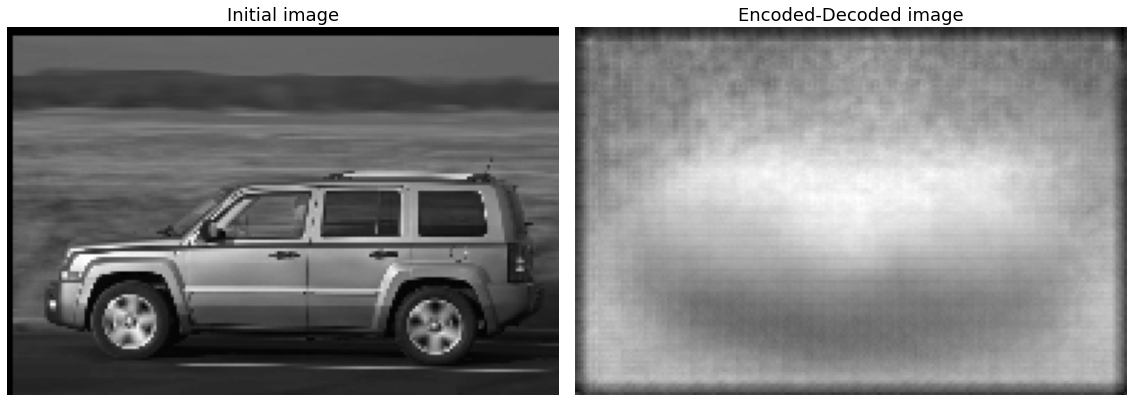

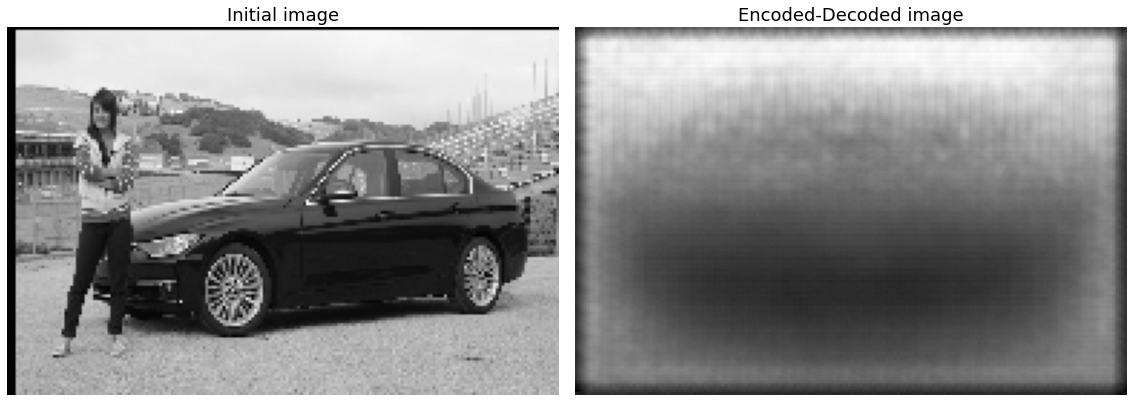

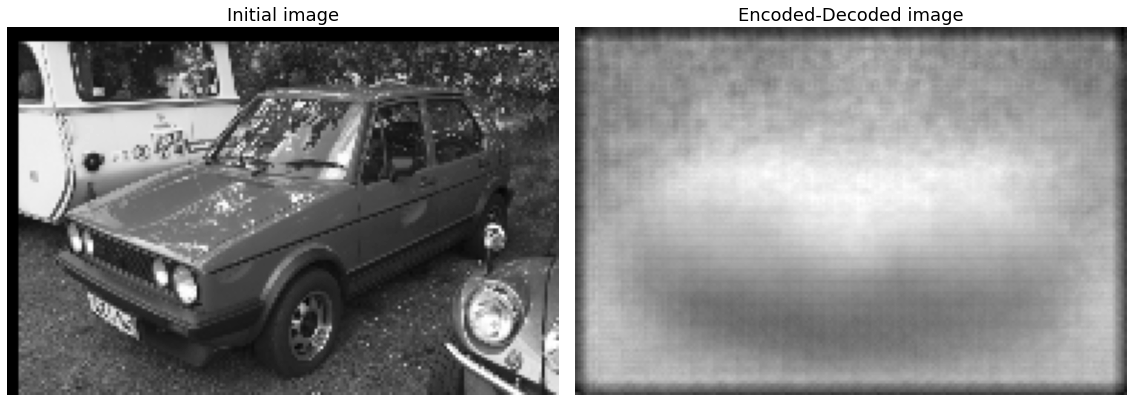

In [47]:
for i in [10,20,30]:
    show_reconstr_hor(images[i,:,:,:],vae_model)